# Ансамбли моделей машинного обучения

Цель лабораторной работы: изучение ансамблей моделей машинного обучения.
Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. 
Сравните качество полученных моделей.
5. Произведите для каждой модели подбор значений одного гиперпараметра.
В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор 
параметров в цикле, или использовать другие методы.
6. Повторите пункт 4 для найденных оптимальных значений гиперпараметров. 
Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
data = pd.read_csv('Data/lab_4/heart.csv',sep=",")
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
data.shape

(303, 14)

In [3]:
# Проверка на пустые значения
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on data, transform  data
scaler.fit_transform(data)


array([[0.70833333, 1.        , 1.        , ..., 0.        , 0.33333333,
        1.        ],
       [0.16666667, 1.        , 0.66666667, ..., 0.        , 0.66666667,
        1.        ],
       [0.25      , 0.        , 0.33333333, ..., 0.        , 0.66666667,
        1.        ],
       ...,
       [0.8125    , 1.        , 0.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.58333333, 1.        , 0.        , ..., 0.25      , 1.        ,
        0.        ],
       [0.58333333, 0.        , 0.33333333, ..., 0.25      , 0.66666667,
        0.        ]])

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import pylab as pl

In [6]:
# Пустых значений нет
# Перейдем к разделению выборки на обучающую и тестовую.
X = data.drop('target',axis = 1).values
y = data['target'].values

### Ансамблевые модели

In [7]:
from sklearn.model_selection import train_test_split
kfold = 5 #количество подвыборок для валидации
itog_val = {} #список для записи результатов кросс валидации разных алгоритмов

In [8]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = train_test_split(X, y, test_size=0.25) 

In [9]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC() #по умолчанию kernek='rbf'

In [10]:
from sklearn.model_selection import cross_val_score

SVM - метод опорных векторов(SVC): 
Суть работы “Машин” Опорных Векторов проста: 
  алгоритм создает линию или гиперплоскость, которая разделяет данные на классы.
Метод k-ближайших соседей(KNeighborsClassifier)
Random forest(RandomForestClassifier)
Логистическая регрессия ( LogisticRegression)

In [11]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

In [12]:
scores = cross_val_score(model_rfc, X, y, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_val_score(model_knc, X, y, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_val_score(model_lr, X, y, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_val_score(model_svc, X, y, cv = kfold)
itog_val['SVC'] = scores.mean()

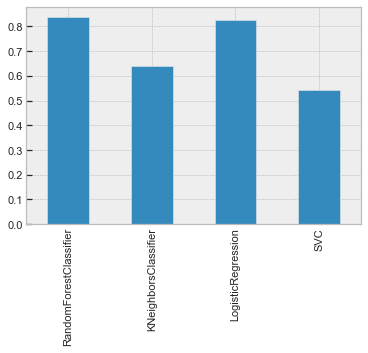

In [13]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
data.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

<Figure size 432x288 with 0 Axes>

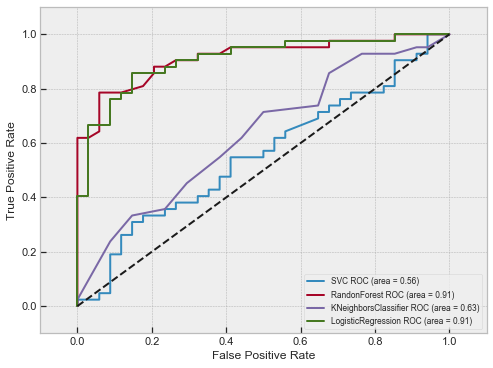

In [14]:
pl.clf()
plt.figure(figsize=(8,6))
#SVC
model_svc.probability = True
probas = model_svc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SVC', roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandonForest',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([-0.1, 1.1])
pl.ylim([-0.1, 1.1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [16]:
from sklearn.model_selection import train_test_split
# Функция train_test_split разделила исходную выборку таким образом, 
#чтобы в обучающей и тестовой частях сохранились пропорции классов.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on data, transform  data
scaler.fit_transform(X)
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)

array([[0.77777778, 0.        , 0.        , ..., 0.        , 0.75      ,
        1.        ],
       [0.61111111, 1.        , 0.33333333, ..., 1.        , 0.        ,
        1.        ],
       [0.38888889, 1.        , 0.        , ..., 1.        , 0.5       ,
        1.        ],
       ...,
       [0.52777778, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.66666667, 1.        , 0.33333333, ..., 0.5       , 1.        ,
        1.        ],
       [0.38888889, 1.        , 0.33333333, ..., 0.        , 0.        ,
        1.        ]])

In [18]:
# n_estimators = 10 (default)
rfc = RandomForestClassifier().fit(X_train, y_train)
predicted_rfc = rfc.predict(X_test)

In [19]:
accuracy_score(y_test, predicted_rfc)

0.7570093457943925

In [20]:
balanced_accuracy_score(y_test, predicted_rfc)

0.7547368421052632

In [21]:
(precision_score(y_test, predicted_rfc, average='weighted'), 
 recall_score(y_test, predicted_rfc, average='weighted'))

(0.7567717408522097, 0.7570093457943925)

In [22]:
f1_score(y_test, predicted_rfc, average='weighted')

0.7566245963419206

In [23]:
# n_estimators = 50 (default)
abc = AdaBoostClassifier().fit(X_train, y_train)
predicted_abc = abc.predict(X_test)

In [24]:
accuracy_score(y_test, predicted_abc)

0.7289719626168224

In [25]:
balanced_accuracy_score(y_test, predicted_abc)

0.7284210526315789

In [26]:
(precision_score(y_test, predicted_abc, average='weighted'), 
 recall_score(y_test, predicted_abc, average='weighted'))

(0.7293842770753162, 0.7289719626168224)

In [27]:
f1_score(y_test, predicted_abc, average='weighted')

0.7291144464706996

In [28]:
rfc_n_range = np.array(range(5,100,5))
rfc_tuned_parameters = [{'n_estimators': rfc_n_range}]
rfc_tuned_parameters

[{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
         90, 95])}]

In [29]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

gs_rfc = GridSearchCV(RandomForestClassifier(), rfc_tuned_parameters, cv=5,
                      scoring='accuracy')
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [30]:
gs_rfc.best_params_

{'n_estimators': 85}

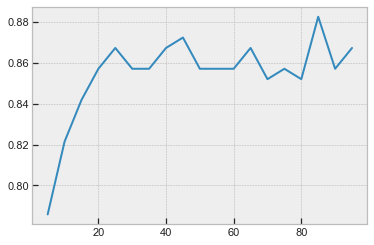

In [31]:
plt.plot(rfc_n_range, gs_rfc.cv_results_['mean_test_score'])

In [32]:
abc_n_range = np.array(range(5,100,5))
abc_tuned_parameters = [{'n_estimators': abc_n_range}]
abc_tuned_parameters

[{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
         90, 95])}]

In [33]:
gs_abc = GridSearchCV(AdaBoostClassifier(), abc_tuned_parameters, cv=5,
                      scoring='accuracy')
gs_abc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [34]:
gs_abc.best_params_

{'n_estimators': 25}

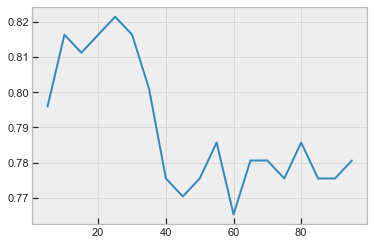

In [35]:
plt.plot(abc_n_range, gs_abc.cv_results_['mean_test_score'])

In [36]:
rfc_optimized = RandomForestClassifier(n_estimators=gs_rfc.best_params_['n_estimators']).fit(X_train, y_train)
predicted_rfc_opt = rfc_optimized.predict(X_test)

In [37]:
accuracy_score(y_test, predicted_rfc_opt)

0.7663551401869159

In [38]:
balanced_accuracy_score(y_test, predicted_rfc_opt)

0.7635087719298246

In [39]:
(precision_score(y_test, predicted_rfc_opt, average='weighted'), 
 recall_score(y_test, predicted_rfc_opt, average='weighted'))

(0.7663352555179958, 0.7663551401869159)

In [40]:
f1_score(y_test, predicted_rfc_opt, average='weighted')

0.765737522265126

In [41]:
abc_optimized = RandomForestClassifier(n_estimators=gs_abc.best_params_['n_estimators']).fit(X_train, y_train)
predicted_abc_opt = abc_optimized.predict(X_test)

In [42]:
accuracy_score(y_test, predicted_abc_opt)

0.7476635514018691

In [43]:
balanced_accuracy_score(y_test, predicted_abc_opt)

0.7471929824561403

In [44]:
(precision_score(y_test, predicted_abc_opt, average='weighted'), 
 recall_score(y_test, predicted_abc_opt, average='weighted'))

(0.748059504175502, 0.7476635514018691)

In [45]:
f1_score(y_test, predicted_abc_opt, average='weighted')

0.7477962087830651